In [1]:
#this part of code is to upload and save the data(photos) in cloud, so that will save our memory

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2022-12-15 05:56:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 172.253.123.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   160MB/s    in 1.2s    

2022-12-15 05:56:32 (160 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2022-12-15 05:56:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 172.253.123.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving t

In [2]:
#that for creating the directory in my local machine if I need to download the data from the cloud
import os
import zipfile

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [3]:
#that detrmine the path of each set of the gestures

rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

#print some information about the data

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])
     

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock07-k03-113.png', 'rock02-117.png', 'rock05ck01-072.png', 'rock07-k03-118.png', 'rock02-104.png', 'rock07-k03-065.png', 'rock04-078.png', 'rock02-072.png', 'rock02-109.png', 'rock01-095.png']
['paper01-092.png', 'paper06-017.png', 'paper06-026.png', 'paper05-103.png', 'paper04-016.png', 'paper01-024.png', 'paper05-074.png', 'paper01-011.png', 'paper06-041.png', 'paper02-065.png']
['scissors03-075.png', 'scissors02-041.png', 'testscissors03-047.png', 'scissors01-047.png', 'testscissors03-033.png', 'scissors02-071.png', 'scissors02-061.png', 'testscissors01-042.png', 'scissors02-034.png', 'testscissors02-105.png']


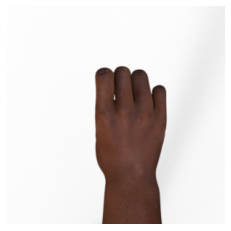

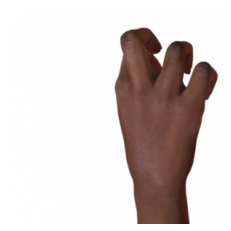

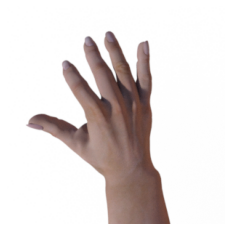

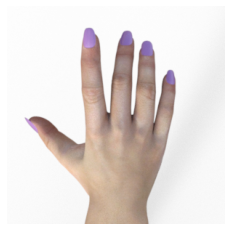

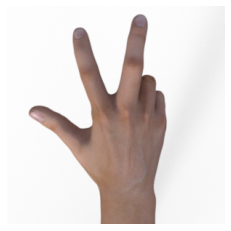

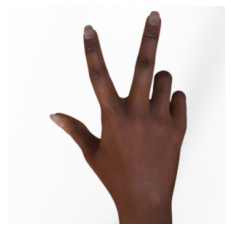

In [4]:
#visualise the data

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [5]:
#that is for training the model

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/rps/"
#this generator is a quick way to generate data in different variants without using a lot of memory.
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit_generator(train_generator, epochs=25, validation_data = validation_generator, verbose = 1)

model.save("rps.h5")

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                       

<ipython-input-5-e3bd94afe004>:56: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=25, validation_data = validation_generator, verbose = 1)


Epoch 1/25
79/79 [==============================] - 214s 3s/step - loss: 1.1657 - accuracy: 0.3802 - val_loss: 0.8674 - val_accuracy: 0.4973
Epoch 2/25
79/79 [==============================] - 198s 3s/step - loss: 0.8332 - accuracy: 0.5940 - val_loss: 0.3131 - val_accuracy: 0.9409
Epoch 3/25
79/79 [==============================] - 199s 3s/step - loss: 0.5390 - accuracy: 0.7726 - val_loss: 0.1208 - val_accuracy: 0.9704
Epoch 4/25
79/79 [==============================] - 195s 2s/step - loss: 0.3888 - accuracy: 0.8496 - val_loss: 0.4474 - val_accuracy: 0.7608
Epoch 5/25
79/79 [==============================] - 203s 3s/step - loss: 0.2700 - accuracy: 0.9016 - val_loss: 0.2117 - val_accuracy: 0.8925
Epoch 6/25
79/79 [==============================] - 198s 3s/step - loss: 0.2355 - accuracy: 0.9155 - val_loss: 0.0843 - val_accuracy: 0.9651
Epoch 7/25
79/79 [==============================] - 198s 3s/step - loss: 0.1928 - accuracy: 0.9302 - val_loss: 0.0628 - val_accuracy: 0.9839
Epoch 8/25
79

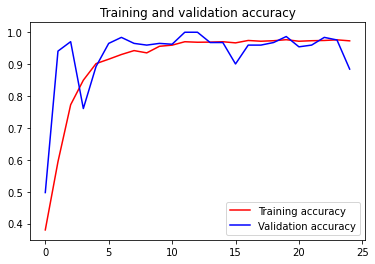

<Figure size 432x288 with 0 Axes>

In [6]:
#check if the accuracy satisfied or not.
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']



epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [41]:

import numpy as np
from google.colab import files
# from keras.preprocessing import image
import keras.utils as image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)
     

Saving paper01-109.png to paper01-109 (1).png
1/1 [==============================] - 0s 43ms/step
paper01-109.png
[[1. 0. 0.]]


In [12]:
#load h5 module
model=tf.keras.models.load_model('rps.h5')
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [13]:
#convert
tflite_model = tflite_converter.convert()
open("tf_lite_model.tflite", "wb").write(tflite_model)

13898584